In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import (preprocess_input)
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET_F1"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # ✅ Smaller for BN layers
EPOCHS = 30
LEARNING_RATE = 1e-5  # ✅ Lower for frozen backbone

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 32460


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 25968 | Val samples: 6492


In [5]:
# === Color Jitter ===
def color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return tf.clip_by_value(image, 0.0, 255.0)  # Important: keep in original range if using preprocess_input

# === GridMask ===
def grid_mask(image, d_min=50, d_max=100, ratio=0.5):
    h, w, _ = image.shape
    d = tf.random.uniform([], d_min, d_max, dtype=tf.int32)
    l = tf.cast(tf.cast(d, tf.float32) * ratio, tf.int32)

    mask = tf.ones([h, w], dtype=tf.float32)

    for i in range(0, h, d):
        for j in range(0, w, d):
            y1 = i
            y2 = tf.minimum(i + l, h)
            x1 = j
            x2 = tf.minimum(j + l, w)

            y_range = tf.range(y1, y2)
            x_range = tf.range(x1, x2)
            yy, xx = tf.meshgrid(y_range, x_range, indexing='ij')
            indices = tf.stack([yy, xx], axis=-1)
            indices = tf.reshape(indices, [-1, 2])

            mask = tf.tensor_scatter_nd_update(
                mask,
                indices,
                tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.float32)
            )

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.tile(mask, [1, 1, 3])
    return image * mask

# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = color_jitter(img)  # keep values 0-255
    img = grid_mask(img)     # keep values 0-255

    img = preprocess_input(img)  # ✅ For ResNet50: scale to [-1, 1] the same way as pretraining

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

# # === CutMix ===
# def cutmix(images, labels, alpha=1.0):
#     batch_size = tf.shape(images)[0]
#     img_h = tf.shape(images)[1]
#     img_w = tf.shape(images)[2]

#     lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])

#     rand_idx = tf.random.shuffle(tf.range(batch_size))
#     images2 = tf.gather(images, rand_idx)
#     labels2 = tf.gather(labels, rand_idx)

#     cut_rat = tf.math.sqrt(1. - lam)
#     cut_w = tf.cast(img_w, tf.float32) * cut_rat
#     cut_h = tf.cast(img_h, tf.float32) * cut_rat

#     cx = tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32))
#     cy = tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32))

#     x1 = tf.cast(cx - cut_w / 2, tf.int32)
#     y1 = tf.cast(cy - cut_h / 2, tf.int32)
#     x2 = tf.cast(cx + cut_w / 2, tf.int32)
#     y2 = tf.cast(cy + cut_h / 2, tf.int32)

#     x1 = tf.clip_by_value(x1, 0, img_w)
#     y1 = tf.clip_by_value(y1, 0, img_h)
#     x2 = tf.clip_by_value(x2, 0, img_w)
#     y2 = tf.clip_by_value(y2, 0, img_h)

#     def apply_cutmix(i):
#         img1 = images[i]
#         img2 = images2[i]
#         bbx1, bby1, bbx2, bby2 = x1[i], y1[i], x2[i], y2[i]

#         mask = tf.pad(
#             tf.zeros([bby2 - bby1, bbx2 - bbx1, 3]),
#             [[bby1, img_h - bby2],
#              [bbx1, img_w - bbx2],
#              [0, 0]],
#             constant_values=1.0
#         )
#         mask = 1.0 - mask
#         mixed = img1 * mask + img2 * (1.0 - mask)

#         area = tf.cast(bbx2 - bbx1, tf.float32) * tf.cast(bby2 - bby1, tf.float32)
#         lam_adjusted = 1.0 - (area / tf.cast(img_w * img_h, tf.float32))
#         new_label = lam_adjusted * labels[i] + (1.0 - lam_adjusted) * labels2[i]

#         return mixed, new_label

#     mixed_images, mixed_labels = tf.map_fn(
#         apply_cutmix,
#         tf.range(batch_size),
#         fn_output_signature=(tf.float32, tf.float32)
#     )

#     return mixed_images, mixed_labels

In [6]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
# train_ds = train_ds.map(lambda x, y: cutmix(x, y)).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === DenseNet50 Model ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Unfreeze last 30 layers
for layer in base_model.layers:    #[:-30]:
    layer.trainable = False
# for layer in base_model.layers[-30:]:
#     layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Important: BN layers training mode ON for partial unfrozen!
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

29084464/29084464 [==============================] - 5s 0us/step


In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASSES)),
    y=y_train_int
)))
print("✅ Computed class weights:", class_weights)

✅ Computed class weights: {0: 0.9976947902259106, 1: 1.0065116279069768, 2: 0.9925087907047851, 3: 1.003400309119011}


In [9]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()],
    class_weight=class_weights
)

Epoch 1/30
📉 Learning rate at epoch 1: 0.000010==] - ETA: 0s - loss: 1.4150 - accuracy: 0.3616     
812/812 [==============================] - 205s 245ms/step - loss: 1.4150 - accuracy: 0.3616 - val_loss: 1.1719 - val_accuracy: 0.5206
Epoch 2/30
📉 Learning rate at epoch 2: 0.000010==] - ETA: 0s - loss: 1.1926 - accuracy: 0.5002  
812/812 [==============================] - 187s 230ms/step - loss: 1.1926 - accuracy: 0.5002 - val_loss: 1.0617 - val_accuracy: 0.5915
Epoch 3/30
📉 Learning rate at epoch 3: 0.000010==] - ETA: 0s - loss: 1.1135 - accuracy: 0.5495  
812/812 [==============================] - 184s 226ms/step - loss: 1.1135 - accuracy: 0.5495 - val_loss: 1.0153 - val_accuracy: 0.6191
Epoch 4/30
📉 Learning rate at epoch 4: 0.000010==] - ETA: 0s - loss: 1.0619 - accuracy: 0.5851  
812/812 [==============================] - 182s 225ms/step - loss: 1.0619 - accuracy: 0.5851 - val_loss: 0.9907 - val_accuracy: 0.6302
Epoch 5/30
📉 Learning rate at epoch 5: 0.000010==] - ETA: 0s - loss: 

1/1 [==============================] - 1s 1s/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       0.90      0.86      0.88      1666
       BLAST       0.65      0.56      0.60      1608
   BROWNSPOT       0.78      0.74      0.76      1614
     HEALTHY       0.70      0.86      0.77      1604

    accuracy                           0.76      6492
   macro avg       0.76      0.75      0.75      6492
weighted avg       0.76      0.76      0.75      6492



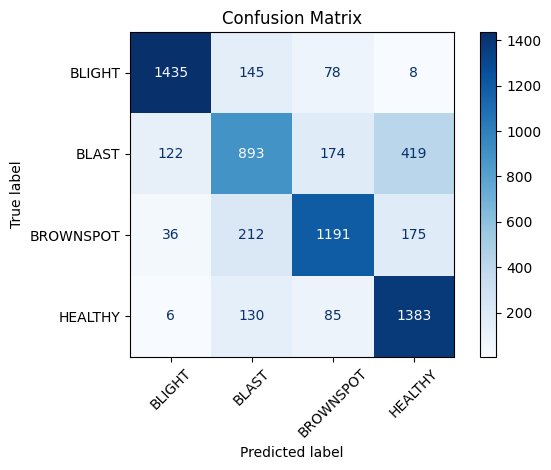

✅ Model saved at: Desktop\Machine Learning\CP_MODEL\DenseNet121_Phase1_GridMask.h5


In [10]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
SAVE_PATH = r"Desktop\Machine Learning\CP_MODEL\DenseNet121_Phase1_GridMask.h5"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")
